## Introduction
This project aims to build an image classifier that can differentiate happy dogs and sad dogs. As a dog lover, I spend a lot of time with my puppy Lukcy, but sometimes, it is hard to tell if she is happy or not just by looking at her. Based on the tons of happy/sad dog images available on Google, I hope to train a model that can help me finding out if Lucky is happy.

As part of this project, the effect of hyperparameter tuning will be focused. Among many, learning rate and batch size are important as they greatly affect on model's potential performance. Learning curves of different combinations of these hyperparameters will be compared to carefully evaluate the effect of each on the final classification accuracy.

## Dataset preparation (download) from online
A `google_images_download` module provides a handy tool to collect images from Google based on custom search queries and criterias. For the practical usage of this module, more information can be found [here](https://github.com/sungsujaing/ML_DL_articles_resources/blob/master/Preparing%20your%20own%20image%20dataset.md).

In [1]:
from google_images_download import google_images_download
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')

In order to get many images for happy/sad dogs, additional search queries are provided ('smiling dogs' and 'frown dogs').  

In [2]:
response = google_images_download.googleimagesdownload()
search_queries = ['happy dogs','smiling dogs','sad dogs','frown dogs']

In [3]:
def downloadimages(query):
    arguments = dict(keywords=query,
                    limit=1000,
                    format='jpg',
                    chromedriver='C:\\Users\\sungsooc\\Documents\\chromedriver_win32\\chromedriver.exe', 
                    silent_mode=True)
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = dict(keywords=query,
                    limit=20,
                    format='jpg',
                    print_urls=True)                       
        try:  
            response.download(arguments)  
        except: 
            pass

In [4]:
download_msg = []
for query in search_queries: 
    downloadimages(query)
    msg = 'Downloaded {} {} images!'.format(len(os.listdir(os.path.join(data_path,query))),query)
    download_msg.append(msg)
for msg in download_msg:
    print(msg)

Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 683 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 533 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 349 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 653 is all we got for this search filter!
Downloaded 681 happy dogs images!
Downloaded 533 smiling dogs images!
Downloaded 346 sad dogs images!
Downloaded 652 frown dogs images!


Even though 1000 images were requested for each search query, not all were downloadable.
#### NOTE: Images were simply downloaded based on the search queries with minimal degree of filters. Therefore, at this stage, it is required to manually go over the downloaded files to get rid of "bad" images. 

### Processing into two categories

In [5]:
import shutil
data_folders = os.listdir(data_path)

source_happy = os.path.join(data_path,'smiling dogs')
dest_happy = os.path.join(data_path,'happy dogs')
source_sad = os.path.join(data_path,'frown dogs')
dest_sad = os.path.join(data_path,'sad dogs')

files_happy = os.listdir(source_happy)
files_sad = os.listdir(source_sad)
for f in files_happy:
    if not os.path.exists(os.path.join(dest_happy,f)):
        shutil.move(os.path.join(source_happy,f), dest_happy)   
for f in files_sad:
    if not os.path.exists(os.path.join(dest_sad,f)):
        shutil.move(os.path.join(source_sad,f), dest_sad)
        
shutil.rmtree(os.path.join(data_path,'smiling dogs'))
shutil.rmtree(os.path.join(data_path,'frown dogs'))

### Optional: file renaming
Downloaded images have arbitrary names set by uploaders. This optional step simply renames the images in each folder to be organized by numbers. While it is not necessary for loading and training, this will be helpful when specific images need to be tracked down quickly during debugging. 

In [6]:
data_folders = os.listdir(data_path)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for i in range(len(os.listdir(working_dir))):
        original_name = current_list[i]
        new_name = "".join(folder.split()) + '_{:04d}'.format(i+1) + os.path.splitext(original_name)[-1]
        if not os.path.exists(new_name):
            os.rename(original_name,new_name)
os.chdir(original_path)

In [12]:
## dummy cells
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')
data_folders = os.listdir(data_path)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Display sample images

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

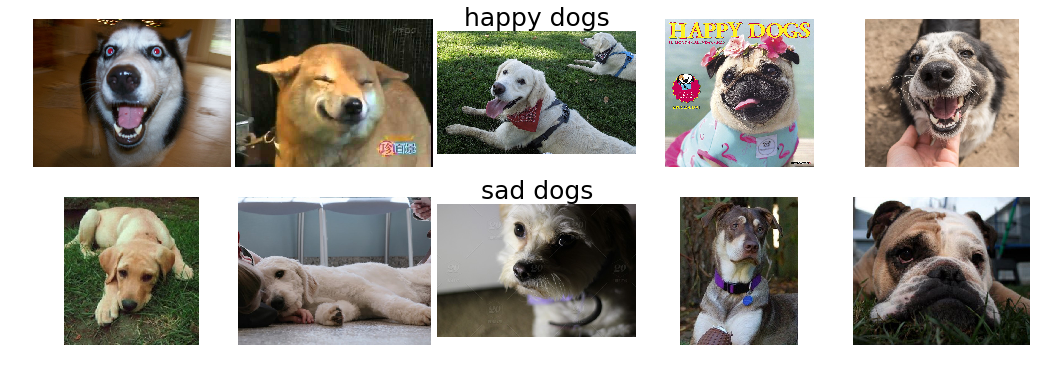

In [8]:
np.random.seed(seed=0)
n_samples = 5
fig, row = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))

for col,folder in zip(row,data_folders):
    col[int(np.floor(n_samples/2))].set_title(folder,fontsize=25)
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    for col_ax,img in zip(col,np.random.choice(os.listdir(os.getcwd()),n_samples,replace=False)):
#         print(img)
        rand_img = cv2.imread(img)
        rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
        col_ax.imshow(rand_img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)
os.chdir(original_path)

## Load and pre-processing

In [9]:
%%time
img_rows = 224
img_cols = 224
img_list = []
label_list = []
labels = dict([('sad dogs',0),('happy dogs',1)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols),cv2.INTER_AREA)
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

Wall time: 13.6 s


### normalization

In [10]:
img_data = np.array(img_list).astype(np.float32)
img_label = np.array(label_list)
img_data /= np.max(img_data)

## Splitting

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.2,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1048, 224, 224, 3)
y_train shape: (1048,)
X_valid shape: (131, 224, 224, 3)
y_valid shape: (131,)
X_test shape: (131, 224, 224, 3)
y_test shape: (131,)


## Model building

### directory to save best models

In [12]:
os.mkdir('best_models_v2')

### import modules and params

In [13]:
from keras import initializers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Add
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [14]:
%load_ext autoreload
%autoreload 2
import helper_module as hm

### Hyperparam search with Model #1: arbitrary CNN - initial trial (~ResNet) with Data augmentation
As an initial model, a simple resnet-like model was built. As the available dataset is small, it is augmented using `ImageDataGenerator`.

In [15]:
def identity_block(n_f,x):
    shortcut = x
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut,x])
    x = Activation('relu')(x)
    return x

def conv_block(n_f,x):
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    return x

In [16]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2, ######### modified
                             rotation_range=45)

In [17]:
inputs = Input(shape=img_data[0].shape)

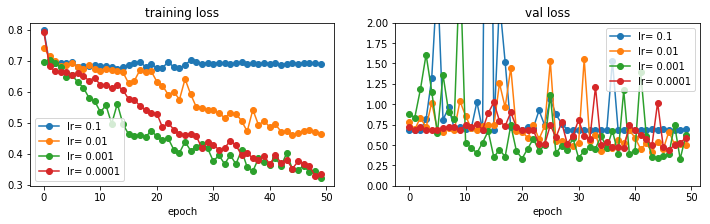

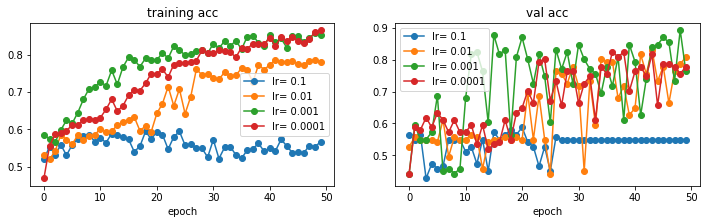

In [18]:
epochs = 50
batch_size = 16
lr_search = [0.1,0.01,0.001,0.0001]

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(2):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(2):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1,activation='sigmoid')(x)
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_valid,y_valid))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['acc'],hist.history['val_acc']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
        if ax == axes_loss[1]:
            ax.set_ylim([0,2])
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

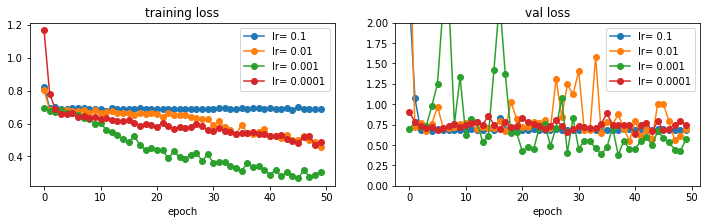

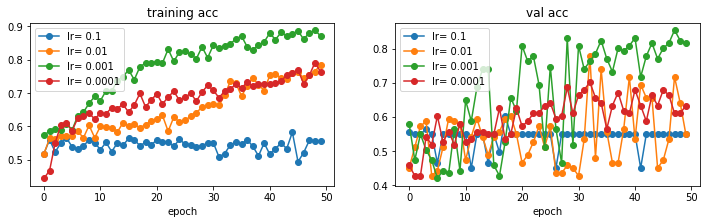

In [19]:
epochs = 50
batch_size = 32
lr_search = [0.1,0.01,0.001,0.0001]

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(2):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(2):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1,activation='sigmoid')(x)
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_valid,y_valid))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['acc'],hist.history['val_acc']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
        if ax == axes_loss[1]:
            ax.set_ylim([0,2])
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

From the search above, lr of 0.1 and 0.01 turned out to be too large for the dataset on hand; loss and accuracy were barely improving over epochs as the model was bouncing back and forth, failing to go into minimas. The models with lr of 0.001 and 0.0001 were both learning, but it was shown that lr of somewhere inbetween those two would be ideal. Thus, 0.0005 is chosen as a learning rate for the models explored in the following sections.

Regarding the batch size, difference between 32 and 16 were not much distinctive in 50 epochs tested. As an experiment, for different models to be tested, both batch sizes of 32 and 16 will be tested/compared. 

## Model #1: arbitrary CNN - initial trial (~ResNet) with Data augmentation

### Model #1, batch = 32

In [20]:
epochs = 200
batch_size = 32 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [21]:
model_name = 'Model_1'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(2):
    x = identity_block(32,x)
x = conv_block(64,x)
for _ in range(2):
    x = identity_block(64,x)

x = GlobalAveragePooling2D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_1 = Model(inputs,outputs)

model_1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_1)

Model_1
Trainable params: 242,113


In [22]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1 = model_1.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_1.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00090: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 1e-05.


131/131 [==============================] - 0s 2ms/step
Valid: accuracy = 0.839695  ;  loss = 0.434037
Test: accuracy = 0.839695  ;  loss = 0.365613


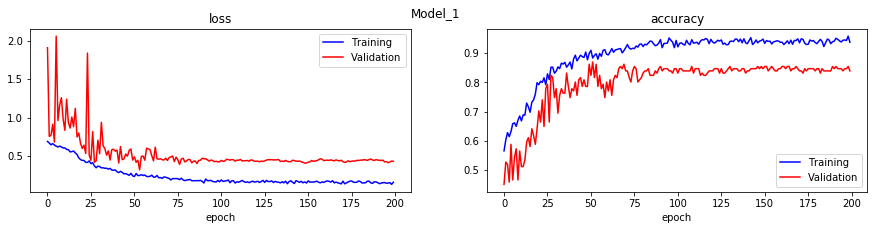

In [23]:
hm.print_valid_test_score(model_1,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_1,model_name)

In [24]:
model_file_name = 'best-wiehgts-Model_1-054-0.323-0.863.hdf5'
chosen_model = load_model(os.path.join('best_models_v2',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
131/131 [==============================] - 1s 8ms/step
Test: accuracy = 0.839695  ;  loss = 0.316027


### Model #1_2, batch = 16

In [25]:
epochs = 200
batch_size = 16 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [26]:
model_name = 'Model_1_2'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(2):
    x = identity_block(32,x)
x = conv_block(64,x)
for _ in range(2):
    x = identity_block(64,x)

x = GlobalAveragePooling2D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_1_2 = Model(inputs,outputs)

model_1_2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_1_2)

Model_1_2
Trainable params: 242,113


In [27]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1_2 = model_1_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_1_2.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1e-05.


131/131 [==============================] - 0s 936us/step
Valid: accuracy = 0.885496  ;  loss = 0.342398
Test: accuracy = 0.908397  ;  loss = 0.292011


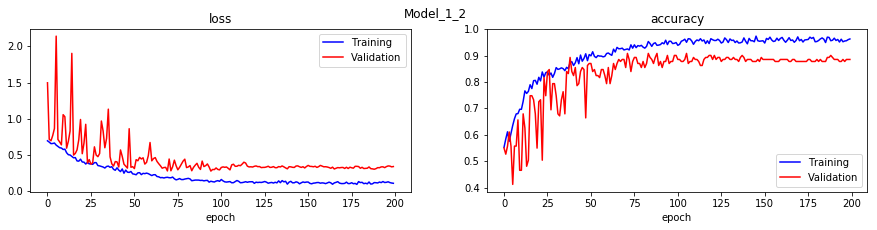

In [28]:
hm.print_valid_test_score(model_1_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_1_2,model_name)

In [29]:
model_file_name = 'best-wiehgts-Model_1_2-095-0.280-0.901.hdf5'
chosen_model = load_model(os.path.join('best_models_v2',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
131/131 [==============================] - 1s 10ms/step
Test: accuracy = 0.862595  ;  loss = 0.290942


The model #1 was a very roughly-built NN composed of residual blocks. Without any efforts on fine-tuning the model, it could achieve ~ 

# RERUN new MODEL #2 with some dropout layers removed

## Model #2:  model #1 with dropouts - handling overfitting
### Model #2, batch = 32

In [30]:
epochs = 200
batch_size = 32 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [31]:
model_name = 'Model_2'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
# x = Dropout(0.25)(x) ######### added

for _ in range(2): 
    x = identity_block(32,x)
x = Dropout(0.5)(x) ######### added
x = conv_block(64,x)
# x = Dropout(0.5)(x) ######### added
for _ in range(2): 
    x = identity_block(64,x)
x = Dropout(0.5)(x) ######### added
    
x = GlobalAveragePooling2D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_2 = Model(inputs,outputs)

model_2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_2)

Model_2
Trainable params: 242,113


In [32]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2 = model_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_2.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 1e-05.


131/131 [==============================] - 0s 982us/step
Valid: accuracy = 0.824427  ;  loss = 0.500282
Test: accuracy = 0.893130  ;  loss = 0.316639


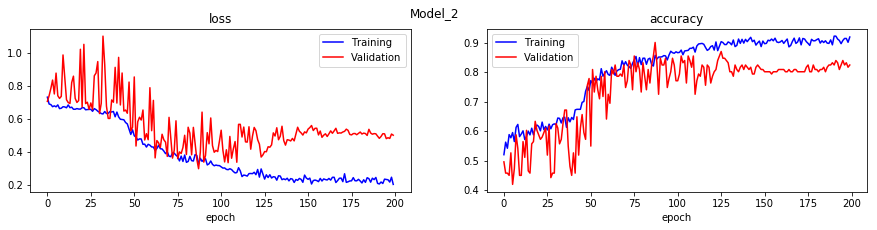

In [33]:
hm.print_valid_test_score(model_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_2,model_name) 

In [34]:
model_file_name = 'best-wiehgts-Model_2-088-0.297-0.901.hdf5'
chosen_model = load_model(os.path.join('best_models_v2',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
131/131 [==============================] - 2s 12ms/step
Test: accuracy = 0.908397  ;  loss = 0.297828


### Model #2_2, batch = 16

In [35]:
epochs = 200
batch_size = 16 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [36]:
model_name = 'Model_2_2'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x = Dropout(0.25)(x) ######### added

for _ in range(2): 
    x = identity_block(32,x)
x = Dropout(0.5)(x) ######### added
x = conv_block(64,x)
x = Dropout(0.5)(x) ######### added
for _ in range(2): 
    x = identity_block(64,x)
x = Dropout(0.5)(x) ######### added
    
x = GlobalAveragePooling2D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_2_2 = Model(inputs,outputs)

model_2_2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_2_2)

Model_2_2
Trainable params: 242,113


In [37]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2_2 = model_2_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_2_2.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1e-05.


131/131 [==============================] - 0s 1ms/step
Valid: accuracy = 0.732824  ;  loss = 0.756850
Test: accuracy = 0.702290  ;  loss = 0.900462


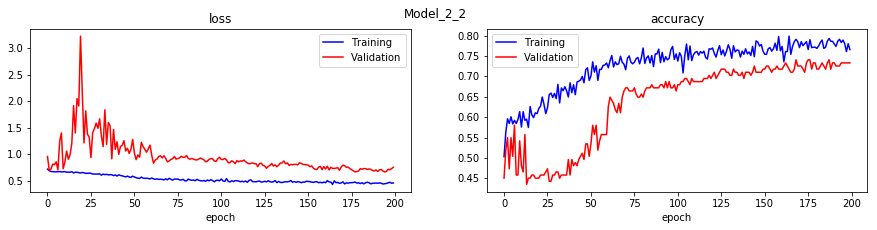

In [38]:
hm.print_valid_test_score(model_2_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_2_2,model_name) 

In [39]:
model_file_name = 'best-wiehgts-Model_2_2-195-0.670-0.733.hdf5'
chosen_model = load_model(os.path.join('best_models_v2',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
131/131 [==============================] - 2s 14ms/step
Test: accuracy = 0.748092  ;  loss = 0.783659


### Model #3: Transfer learnin gon ResNet50

In [ ]:
## dummy cells

In [ ]:
## dummy cells
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')
data_folders = os.listdir(data_path)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras import initializers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Add
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

%load_ext autoreload
%autoreload 2
import helper_module as hm

In [27]:
img_rows = 224
img_cols = 224
img_list = []
label_list = []
labels = dict([('sad dogs',0),('happy dogs',1)])
# reading and resizing (no other preprocessing)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols),cv2.INTER_AREA)
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

img_data = np.array(img_list).astype(np.float32)
img_label = np.array(label_list)

X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.2,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1256, 224, 224, 3)
y_train shape: (1256,)
X_valid shape: (70, 224, 224, 3)
y_valid shape: (70,)
X_test shape: (70, 224, 224, 3)
y_test shape: (70,)


In [28]:
from keras.applications.resnet50 import ResNet50,preprocess_input

In [29]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             rotation_range=45,
                             preprocessing_function=preprocess_input)     
datagen.fit(X_train)

C:\Users\sungsooc\AppData\Local\Continuum\anaconda3\envs\workspace-gpu-custom-keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model_3 before freezing
Trainable params: 23,536,641
Model_3 after freezing
Trainable params: 2,049


In [ ]:
epochs = 200
batch_size = 32 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
import warnings
warnings.simplefilter('ignore') #to suppress userwarning "ResNet50(include_top=False) has been changed since Keras 2.2.0."

model_name = 'Model_3'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
model_3_bottom = ResNet50(include_top=False, weights='imagenet')
last_layer = model_3_bottom.output
x = GlobalAveragePooling2D()(last_layer) #175th layer
outputs = Dense(1, activation='sigmoid')(x)
model_3 = Model(model_3_bottom.input,outputs)

print(model_name+' before freezing')
hm.print_train_num_param(model_3)
for layer in model_3.layers[:175]:
    layer.trainable=False
print(model_name+' after freezing')
hm.print_train_num_param(model_3)

In [30]:
model_3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_3 = model_3.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])


Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 4.117714888707269e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 2.88240029476583e-05.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 2.0176801808702293e-05.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.4123761138762347e-05.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 1e-05.


70/70 [==============================] - 0s 6ms/step
Valid: accuracy = 0.785714  ;  loss = 0.549115
Test: accuracy = 0.757143  ;  loss = 0.615957


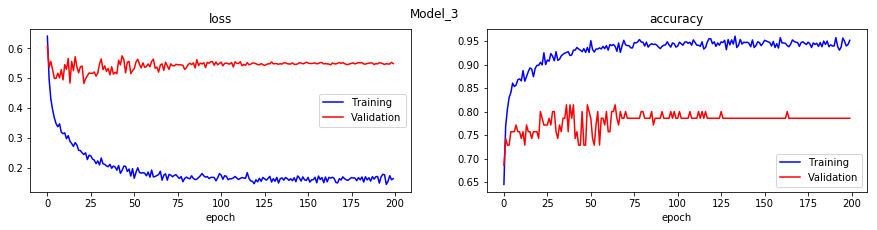

In [31]:
hm.print_valid_test_score(model_3,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_3,model_name) 

In [32]:
model_file_name = 'best-wiehgts-Model_1-047-0.308-0.893.hdf5'
chosen_model = load_model(os.path.join('best_models_v2',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
70/70 [==============================] - 0s 6ms/step
Valid: accuracy = 0.800000  ;  loss = 0.482709
Test: accuracy = 0.771429  ;  loss = 0.562989


## Testing new image of Lucky!

#### For best custom model

In [33]:
img_rows = 224
img_cols = 224

In [32]:
chosen_model = load_model(os.path.join('best_models_v2','.hdf5'))

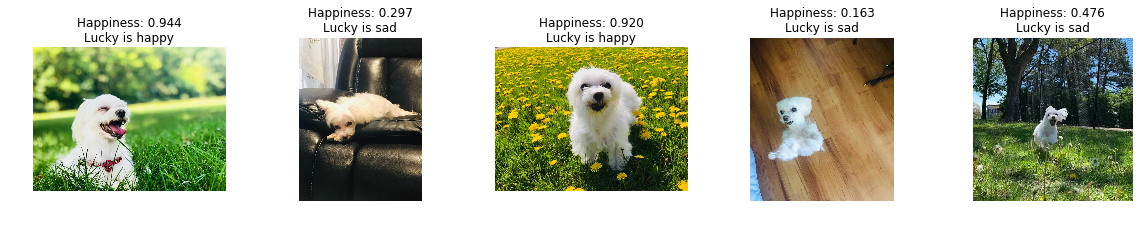

In [33]:
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,range(1,6)):
    img = cv2.imread(os.path.join('test_images','Lucky_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate = chosen_model.predict(img)[0][0]
    if predict_rate >= 0.5:
        predict_class = 'happy'
    else: predict_class = 'sad'
    ax.set_title('Happiness: {:.3f}\nLucky is {}'.format(predict_rate,predict_class))
plt.subplots_adjust(left=0.2, wspace=0.02)


#### For best fine-tuned ResNet50 model

In [11]:
chosen_model= load_model(os.path.join('best_models','best-wiehgts-Model_3-022-0.483-0.800.hdf5'))

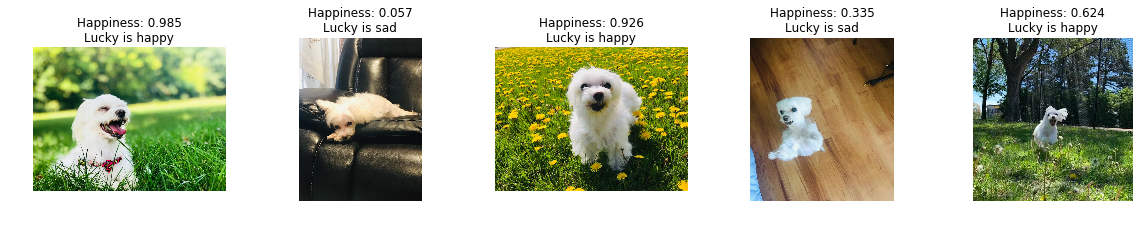

In [12]:
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,range(1,6)):
    img = cv2.imread(os.path.join('test_images','Lucky_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate = chosen_model.predict(img)[0][0]
    if predict_rate >= 0.5:
        predict_class = 'happy'
    else: predict_class = 'sad'
    ax.set_title('Happiness: {:.3f}\nLucky is {}'.format(predict_rate,predict_class))
plt.subplots_adjust(left=0.2, wspace=0.02)

## To do..
* show mislabeled examples
* make the notebook using image generator
* articles about using flow and flow_from_directory